In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Set style for plots
sns.set_style('whitegrid')

df = pd.read_csv('/content/HSBC_ST138D-XLS-ENG.csv')  # Make sure to upload your CSV file to Google Colab
# Handle duplicates
print(f"Initial shape: {df.shape}")
df = df.drop_duplicates()
print(f"Shape after duplicate removal: {df.shape}")
df.head()




Initial shape: (50000, 14)
Shape after duplicate removal: (48772, 14)


,AGE,INCOME,TRB,DIG_ACTIVE,FX_TRANS,PAYME,CC,LN,MT,TD,SC,SP,BD,MPF
0,30-34,9012.13,62051.47,0,0,1,0,0,0,0,0,0,0,1
1,30-34,44108.03,4.05,1,0,0,1,0,0,0,0,0,0,0
2,25-29,45782.41,291996.00,1,0,0,0,0,0,0,0,0,0,0
3,30-34,26525.41,81.50,1,0,0,0,0,0,0,1,0,0,0
4,30-34,20671.51,1447.01,1,0,1,0,0,0,0,0,0,0,0


In [3]:
# Data cleaning
# Clean and convert AGE
def parse_age(x):
    if isinstance(x, str) and '-' in x:
        return int(x.split('-')[0])
    return int(x)

df['AGE'] = df['AGE'].apply(parse_age)

# Convert binary features to integer type
binary_features = ['DIG_ACTIVE', 'FX_TRANS', 'PAYME', 'CC', 'LN', 'MT', 'TD', 'SC', 'SP', 'BD', 'MPF']
for feature in binary_features:
    df[feature] = df[feature].astype('int')

# Check for missing values
print(df.isnull().sum())

# Normalize numerical features (including AGE now)
numerical_features = ['INCOME', 'TRB', 'AGE']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Use these features for K-Means clustering
X = df[numerical_features].values

AGE           0
INCOME        0
TRB           0
DIG_ACTIVE    0
FX_TRANS      0
PAYME         0
CC            0
LN            0
MT            0
TD            0
SC            0
SP            0
BD            0
MPF           0
dtype: int64


                AGE        INCOME           TRB    DIG_ACTIVE      FX_TRANS  \
count  4.877200e+04  4.877200e+04  4.877200e+04  48772.000000  48772.000000   
mean  -3.076901e-16 -2.330986e-17  2.797183e-17      0.823280      0.242578   
std    1.000010e+00  1.000010e+00  1.000010e+00      0.381436      0.428646   
min   -1.407615e+00 -1.961032e+00 -4.217119e-01      0.000000      0.000000   
25%   -1.407615e+00 -4.873295e-01 -4.072174e-01      1.000000      0.000000   
50%    2.614245e-02 -1.597175e-01 -3.177955e-01      1.000000      0.000000   
75%    1.050255e+00  3.329450e-01  2.375582e-02      1.000000      0.000000   
max    1.050255e+00  5.169614e+01  5.724228e+01      1.000000      1.000000   

              PAYME            CC            LN            MT            TD  \
count  48772.000000  48772.000000  48772.000000  48772.000000  48772.000000   
mean       0.668314      0.495674      0.077606      0.078836      0.094932   
std        0.470824      0.499986      0.267553    

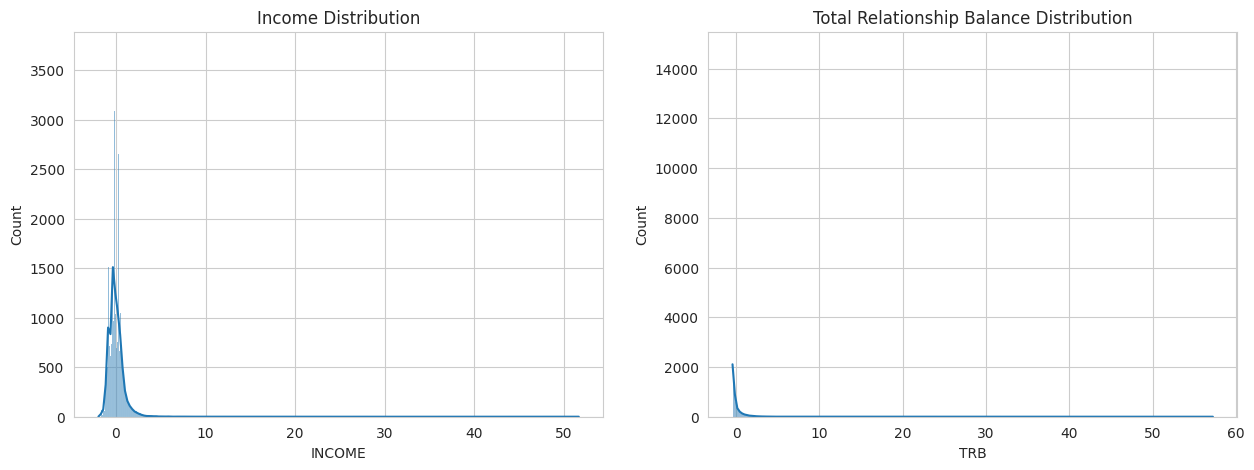

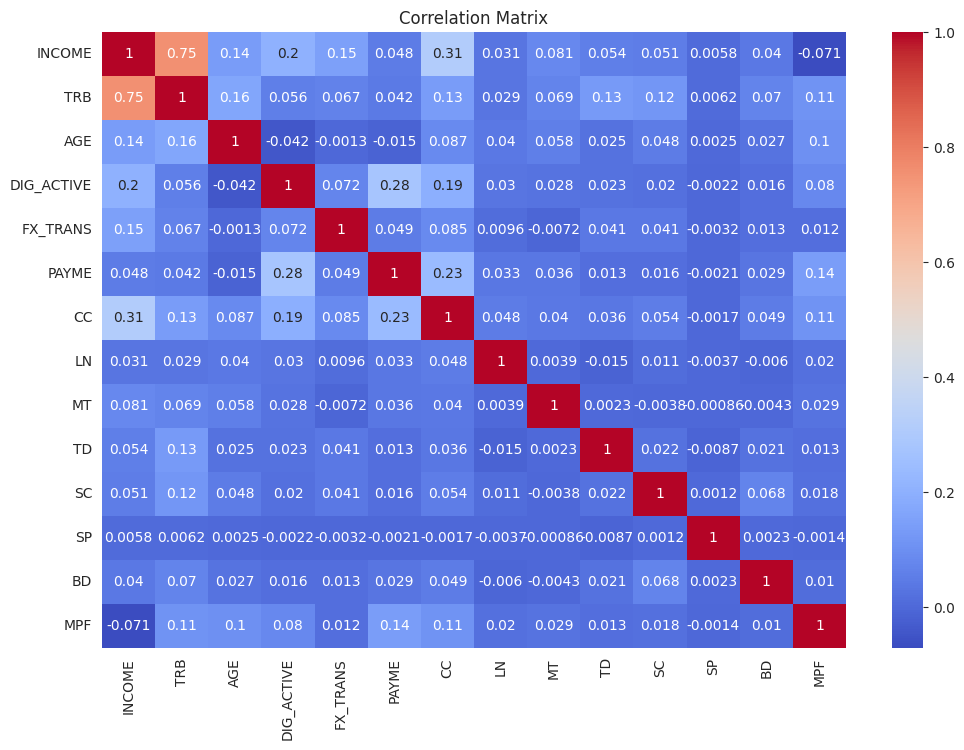

In [4]:
# Summary statistics
print(df.describe())

# Distribution plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['INCOME'], kde=True)
plt.title('Income Distribution')

plt.subplot(1, 2, 2)
sns.histplot(df['TRB'], kde=True)
plt.title('Total Relationship Balance Distribution')
plt.show()

# Correlation matrix (including product adoption)
product_columns = ['DIG_ACTIVE', 'FX_TRANS', 'PAYME', 'CC', 'LN', 'MT', 'TD', 'SC', 'SP', 'BD', 'MPF']
correlation_matrix = df[numerical_features + product_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Top-Down Clustering Evaluation (Elbow Method):


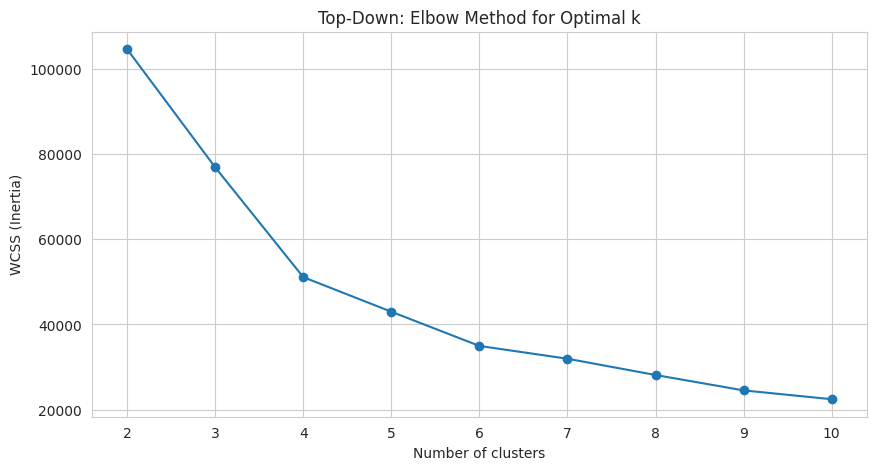


Bottom-Up Clustering Evaluation (Silhouette Scores):
Bottom-Up Silhouette Score for k=6: 0.452
Bottom-Up Silhouette Score for k=5: 0.411
Bottom-Up Silhouette Score for k=4: 0.504
Bottom-Up Silhouette Score for k=3: 0.455
Bottom-Up Silhouette Score for k=2: 0.447


In [5]:
# Top-Down Approach: Elbow Method to determine optimal number of clusters
wcss = []
max_clusters = 10

print("Top-Down Clustering Evaluation (Elbow Method):")
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clusters + 1), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Inertia)')
plt.title('Top-Down: Elbow Method for Optimal k')
plt.show()

# Bottom-Up Approach: Start with more clusters and reduce (reverse loop)
print("\nBottom-Up Clustering Evaluation (Silhouette Scores):")
for k in range(6, 1, -1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    sil_score = silhouette_score(X, labels)
    print(f"Bottom-Up Silhouette Score for k={k}: {sil_score:.3f}")



In [6]:
#using k=4 since it seems to be the best option looking at the graph above
optimal_k = 4

# Fit K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X)

# Add cluster labels to dataframe
df['Cluster'] = clusters

# Cluster interpretation
cluster_summary = df.groupby('Cluster')[numerical_features + product_columns].mean()
print(cluster_summary)

            INCOME        TRB       AGE  DIG_ACTIVE  FX_TRANS     PAYME  \
Cluster                                                                   
0        -0.230679  -0.271276 -1.407615    0.844621  0.238391  0.668095   
1         1.608567   1.904888  0.591030    0.898144  0.370542  0.722521   
2        20.791366  22.273679  0.572336    0.700000  0.166667  0.333333   
3        -0.129859  -0.152349  0.563359    0.803654  0.227471  0.661501   

               CC        LN        MT        TD        SC        SP        BD  \
Cluster                                                                         
0        0.415131  0.061580  0.058151  0.081083  0.077511  0.049293  0.062437   
1        0.739863  0.098681  0.157792  0.195896  0.203224  0.055691  0.124817   
2        0.366667  0.066667  0.066667  0.300000  0.200000  0.100000  0.100000   
3        0.499967  0.082121  0.077749  0.087569  0.093573  0.050440  0.070016   

              MPF  
Cluster            
0        0.215316  
1 

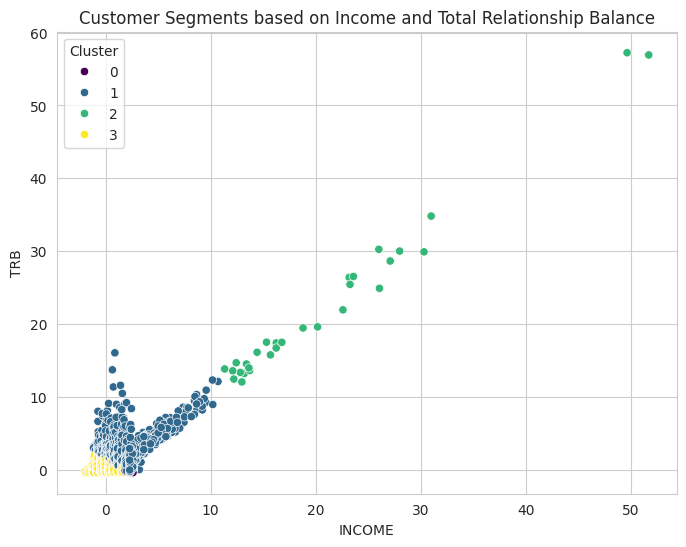

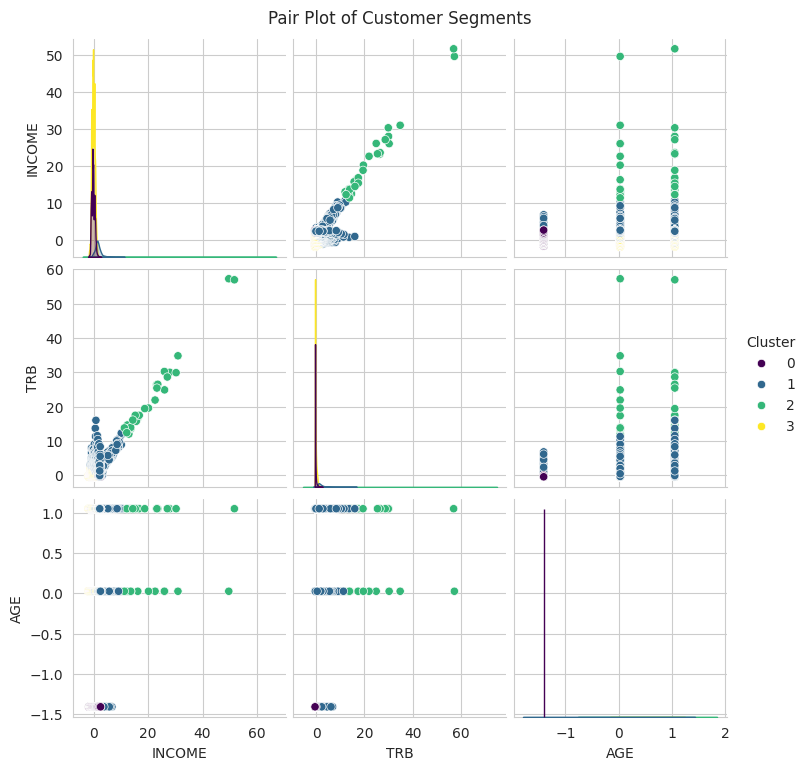

In [7]:
# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='INCOME', y='TRB', hue='Cluster', data=df, palette='viridis')
plt.title('Customer Segments based on Income and Total Relationship Balance')
plt.show()

# Pair plot for selected features
sns.pairplot(df, vars=numerical_features, hue='Cluster', palette='viridis')
plt.suptitle('Pair Plot of Customer Segments', y=1.02)
plt.show()

In [8]:
# Try with K < optimal (e.g., 2)
kmeans_k2 = KMeans(n_clusters=2, random_state=42)
df['Cluster_k2'] = kmeans_k2.fit_predict(X)

# Try with K > optimal (e.g., 6)
kmeans_k6 = KMeans(n_clusters=6, random_state=42)
df['Cluster_k6'] = kmeans_k6.fit_predict(X)

# Compare results
print("\nCluster sizes for k=2:")
print(df['Cluster_k2'].value_counts())

print("\nCluster sizes for k=4 (optimal):")
print(df['Cluster'].value_counts())

print("\nCluster sizes for k=6:")
print(df['Cluster_k6'].value_counts())


Cluster sizes for k=2:
Cluster_k2
1    34587
0    14185
Name: count, dtype: int64

Cluster sizes for k=4 (optimal):
Cluster
3    30650
0    13998
1     4094
2       30
Name: count, dtype: int64

Cluster sizes for k=6:
Cluster_k6
1    15058
5    13966
3    13921
0     5325
4      482
2       20
Name: count, dtype: int64


For k=2, the data is split into two large groups, but this may be too broad to capture meaningful differences between customer segments.

For k=4, the clusters are more balanced and meaningful, although one small cluster (30 customers) may represent a niche group.

For k=6, the clustering creates more detailed segments, but includes very small clusters (e.g., 20 and 482 customers), which may indicate outliers or less useful segments.

In [9]:
# Evaluate cluster quality
silhouette_avg = silhouette_score(X, df['Cluster'])
print(f"Silhouette Score for k=4 (optimal): {silhouette_avg:.3f}")

# Compare with other k values
print(f"Silhouette Score for k=2: {silhouette_score(X, df['Cluster_k2']):.3f}")
print(f"Silhouette Score for k=6: {silhouette_score(X, df['Cluster_k6']):.3f}")


Silhouette Score for k=4 (optimal): 0.504
Silhouette Score for k=2: 0.447
Silhouette Score for k=6: 0.452


the silhouette score is the highest when k is set to 4 meaning it is the best possibe way to cluster the data with the current variables

In [10]:
#Adding new features to improve findings

# 1. INCOME_TO_BALANCE_RATIO: Measures liquidity position
# Practical because: Shows how much balance customers maintain relative to income
# (High ratio = low liquidity, Low ratio = high savings)
df['INCOME_TO_BALANCE_RATIO'] = df['INCOME'] / (df['TRB'] + 1)  # +1 avoids division by zero

# 2. PRODUCT_ADOPTION_SCORE: Count of active products
# Practical because: Direct measure of customer engagement with bank
df['PRODUCT_ADOPTION_SCORE'] = df[product_columns].sum(axis=1)

# 3. DIGITAL_ENGAGEMENT_FLAG: Composite digital activity indicator
# Practical because: Identifies tech-savvy customers for digital marketing
df['DIGITAL_ENGAGEMENT_FLAG'] = (df['DIG_ACTIVE'] + df['PAYME'] + df['FX_TRANS']).apply(lambda x: 1 if x >= 2 else 0)

# 4. CREDIT_USAGE_SCORE: Measures credit product utilization
# Practical because: Identifies credit-active customers for cross-selling
df['CREDIT_USAGE_SCORE'] = (df['CC'] + df['LN'] + df['MT']).apply(lambda x: min(x, 1))

# Normalize new features
scaler = StandardScaler()
new_features = ['INCOME_TO_BALANCE_RATIO', 'PRODUCT_ADOPTION_SCORE',
                'DIGITAL_ENGAGEMENT_FLAG', 'CREDIT_USAGE_SCORE']
df[new_features] = scaler.fit_transform(df[new_features])

# Enhanced feature set
enhanced_features = numerical_features + new_features
X_enhanced = df[enhanced_features].values

# Re-run K-Means with enhanced features
kmeans_enhanced = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster_enhanced'] = kmeans_enhanced.fit_predict(X_enhanced)

# Evaluate enhanced clustering
enhanced_silhouette = silhouette_score(X_enhanced, df['Cluster_enhanced'])
print(f"\nSilhouette Score with enhanced features: {enhanced_silhouette:.3f}")

# Compare cluster characteristics
print("\nEnhanced clusters summary:")
print(df.groupby('Cluster_enhanced')[enhanced_features + product_columns].mean())

# Business interpretation of new features
print("\nFeature Business Significance:")
print("""
1. INCOME_TO_BALANCE_RATIO - Identifies customers who maintain high balances relative to income
   (potential targets for investment products)
2. PRODUCT_ADOPTION_SCORE - Segments customers by their depth of relationship with the bank
3. DIGITAL_ENGAGEMENT_FLAG - Highlights digitally-active customers for app-based offers
4. CREDIT_USAGE_SCORE - Pinpoints credit users for loan product cross-selling
""")


Silhouette Score with enhanced features: 0.280

Enhanced clusters summary:
                    INCOME       TRB       AGE  INCOME_TO_BALANCE_RATIO  \
Cluster_enhanced                                                          
0                -0.399347 -0.235022 -0.319832                -0.514282   
1                 2.817717  3.451554  0.583444                 1.050509   
2                -0.482618 -0.256861 -0.022840                -0.698089   
3                 0.313963  0.040790  0.156393                 0.633444   

                  PRODUCT_ADOPTION_SCORE  DIGITAL_ENGAGEMENT_FLAG  \
Cluster_enhanced                                                    
0                              -0.117433                 0.704749   
1                               0.607593                 0.162558   
2                              -1.109487                -1.418946   
3                               0.678635                 0.418432   

                  CREDIT_USAGE_SCORE  DIG_ACTIVE  FX_TRANS

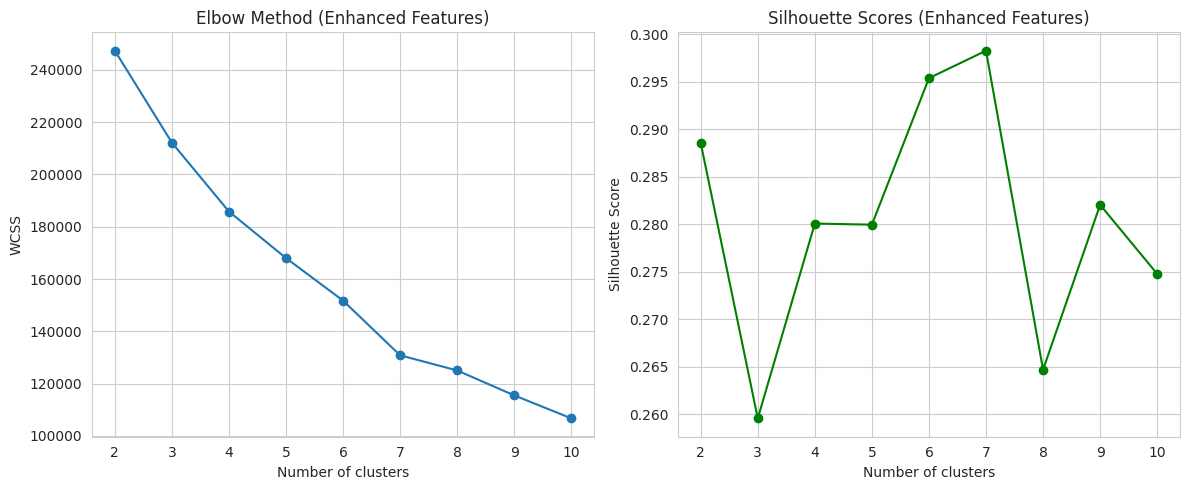

In [11]:
# Re-evaluate best k with enhanced features
wcss_enhanced = []
sil_scores_enhanced = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_enhanced)
    wcss_enhanced.append(kmeans.inertia_)
    sil_scores_enhanced.append(silhouette_score(X_enhanced, labels))

# Plot elbow + silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss_enhanced, marker='o')
plt.title('Elbow Method (Enhanced Features)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), sil_scores_enhanced, marker='o', color='green')
plt.title('Silhouette Scores (Enhanced Features)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


after the new features, the best possible k is 7 so re running the code with k=7 on the enhanced features get a new silhoutte score

In [12]:
# Re-run KMeans with k=7 on enhanced features
kmeans_k7 = KMeans(n_clusters=7, random_state=42)
df['Cluster_k7_enhanced'] = kmeans_k7.fit_predict(X_enhanced)

# Evaluate silhouette score for k=7
silhouette_k7 = silhouette_score(X_enhanced, df['Cluster_k7_enhanced'])
print(f"Silhouette Score for k=7 (enhanced features): {silhouette_k7:.3f}")


Silhouette Score for k=7 (enhanced features): 0.298


this is still low so now adding a chunk of code that selects features instead of just adding them to reduce noise.

In [13]:
selected_features = ['INCOME', 'TRB', 'AGE', 'PRODUCT_ADOPTION_SCORE']
X_selected = df[selected_features].values

# Scale if not already
X_selected = StandardScaler().fit_transform(X_selected)

# KMeans with k=3 or 4 (based on earlier elbow/silhouette)
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster_selected'] = kmeans.fit_predict(X_selected)

# Evaluate
score = silhouette_score(X_selected, df['Cluster_selected'])
print(f"Silhouette Score with selected features: {score:.3f}")


Silhouette Score with selected features: 0.330


improved but still low so now adding a chunk of code that relies on dimensionality reduction to reduce noise and compress the feature space

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_enhanced)

kmeans_pca = KMeans(n_clusters=3, random_state=42)
df['Cluster_pca'] = kmeans_pca.fit_predict(X_pca)

print("Silhouette Score with PCA-reduced features:", silhouette_score(X_pca, df['Cluster_pca']))

Silhouette Score with PCA-reduced features: 0.4278401433608291


this is getting better but now attempting to use PCA along with selection of features

In [15]:
selected = ['INCOME', 'TRB', 'AGE', 'PRODUCT_ADOPTION_SCORE']
X_sel_scaled = scaler.fit_transform(df[selected])
X_pca_sel = PCA(n_components=2).fit_transform(X_sel_scaled)
df['Cluster_hybrid'] = KMeans(n_clusters=3, random_state=42).fit_predict(X_pca_sel)
print("Hybrid PCA Score:", silhouette_score(X_pca_sel, df['Cluster_hybrid']))


Hybrid PCA Score: 0.5119200535044419


this way ive got the highest score meaning clusters are well seperated from each other and the points within the clusters are closest to each other.